# Initializations and Dataset Download

In [106]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Skipping, found downloaded files in "./bean-leaf-lesions-classification" (use force=True to force download)


# Importing the dependencies

In [107]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torchvision import models # import pretrained models in PyTorch library
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac


# Reading Data Paths
The following code will be going through a nested directory structure where images are stored within subdirectories, each directory is representing a specific label (category). It constructs a list of the file paths for these images and their corresponding labels. Then, it creates a pandas DataFrame containing this information, which is useful for further data processing. Keep in mind that we will read all the data and then we will split it again to train, validation and testing.

In [108]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

train_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + train_df["image:FILE"]
val_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + val_df["image:FILE"]

In [109]:
train_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [110]:
train_df["category"].unique()

array([0, 1, 2])

In [111]:
print(train_df.shape)
print(val_df.shape)

(1034, 2)
(133, 2)


In [112]:
print(train_df["category"].value_counts())
print(val_df["category"].value_counts())

category
2    348
1    345
0    341
Name: count, dtype: int64
category
2    45
0    44
1    44
Name: count, dtype: int64


In [113]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

In [114]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(dataframe['category']).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = (self.transform(image)/255)

    return image, label

In [115]:
train_dataset = CustomImageDataset(train_df, transform)
val_dataset = CustomImageDataset(val_df, transform)

## Visualizing the dataset


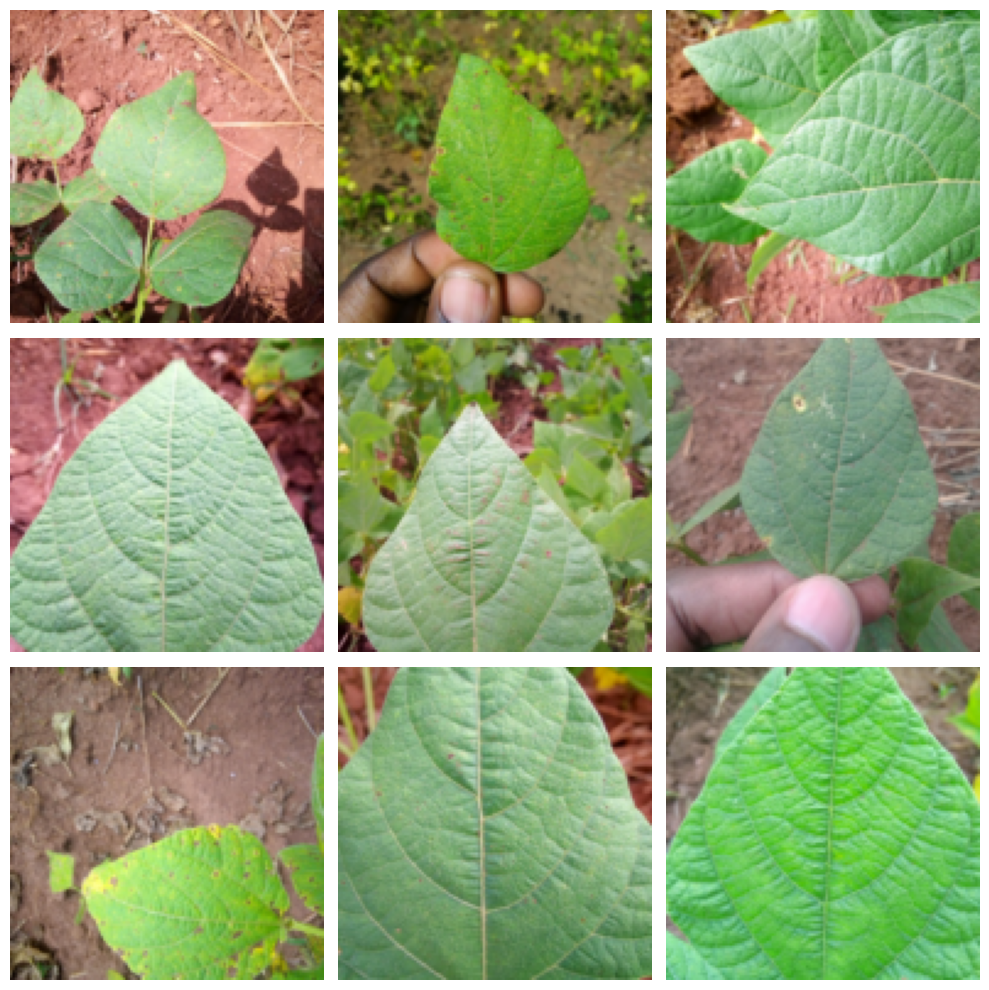

In [116]:
n_rows = 3
n_cols = 3

fig, axarr = plt.subplots(n_rows, n_cols, figsize=(10,10))
for row in range(n_rows):
  for col in range(n_cols):
    image = train_dataset[np.random.randint(0, train_dataset.__len__())][0].cpu()
    axarr[row, col].imshow((image * 255.0).squeeze().permute(1, 2, 0))
    axarr[row, col].axis("off")

plt.tight_layout()
plt.show()

# Hyperparameters

In [117]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15


In [118]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [119]:
googlenet_model = models.googlenet(weights = 'DEFAULT')

In [120]:
for param in googlenet_model.parameters():
  param.requires_grad = True  #allows weights to learn again

In [121]:
googlenet_model.fc  #gives last linear layer

Linear(in_features=1024, out_features=1000, bias=True)

In [122]:
num_classes = len(train_df["category"].unique())
num_classes

3

## New layer


In [123]:
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [124]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

# Training

In [131]:
# 📌 1. Define your loss function — used to compute how "wrong" the model's predictions are
loss_fun = nn.CrossEntropyLoss()

# 📌 2. Define your optimizer — this will update the model's weights to minimize the loss
optimizer = Adam(googlenet_model.parameters(), lr=LR)

# 📌 3. Lists to store loss and accuracy for plotting later
total_loss_train_plot = []
total_acc_train_plot = []

# 🔁 4. Start training loop for defined number of epochs
for epoch in range(EPOCHS):

    # Reset metrics for the new epoch
    total_acc_train = 0        # Total correct predictions
    total_loss_train = 0       # Sum of losses
    total_samples = 0          # Total number of images seen

    # 📌 Set the model to training mode (important for layers like BatchNorm, Dropout)
    googlenet_model.train()

    # 🔁 Loop through batches of images + labels
    for inputs, labels in train_loader:
        # Move inputs and labels to the correct device (GPU/CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Reset gradients from the previous step
        optimizer.zero_grad()

        # 📌 Forward pass: get model predictions for the current batch
        outputs = googlenet_model(inputs)

        # 📌 Compute loss between model predictions and true labels
        train_loss = loss_fun(outputs, labels)

        # 📌 Backpropagation: compute gradients
        train_loss.backward()

        # 📌 Update weights using optimizer
        optimizer.step()

        # Add the current batch loss to the total loss for the epoch
        total_loss_train += train_loss.item()

        # 📌 Compute number of correct predictions in this batch
        correct_preds = (torch.argmax(outputs, dim=1) == labels).sum().item()
        total_acc_train += correct_preds

        # 📌 Keep track of how many samples we've seen so far
        total_samples += labels.size(0)

    #  Compute average loss and accuracy for the epoch
    avg_loss = total_loss_train / len(train_loader)
    accuracy = total_acc_train / total_samples * 100

    # Save loss and accuracy to plot later
    total_loss_train_plot.append(round(avg_loss, 4))
    total_acc_train_plot.append(round(accuracy, 4))

    # 🖨 Print progress
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {round(avg_loss, 4)}, Accuracy: {round(accuracy, 4)}%")


Epoch 1/15 - Loss: 0.3337, Accuracy: 88.2012%
Epoch 2/15 - Loss: 0.3204, Accuracy: 87.911%
Epoch 3/15 - Loss: 0.2766, Accuracy: 89.8453%
Epoch 4/15 - Loss: 0.2848, Accuracy: 89.1683%
Epoch 5/15 - Loss: 0.2268, Accuracy: 91.8762%
Epoch 6/15 - Loss: 0.2717, Accuracy: 89.7485%
Epoch 7/15 - Loss: 0.2451, Accuracy: 91.1025%
Epoch 8/15 - Loss: 0.1669, Accuracy: 94.3907%
Epoch 9/15 - Loss: 0.1998, Accuracy: 91.6828%
Epoch 10/15 - Loss: 0.196, Accuracy: 92.7466%
Epoch 11/15 - Loss: 0.1953, Accuracy: 92.4565%
Epoch 12/15 - Loss: 0.1383, Accuracy: 94.5841%
Epoch 13/15 - Loss: 0.1236, Accuracy: 95.5513%
Epoch 14/15 - Loss: 0.126, Accuracy: 95.1644%
Epoch 15/15 - Loss: 0.1665, Accuracy: 93.2302%


In [138]:
# 📌 Initialize counters for accuracy
total_correct = 0      # Number of correct predictions
total_samples = 0      # Total number of samples evaluated

# 📌 Turn off gradient computation for faster validation & less memory
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to GPU/CPU
        inputs, labels = inputs.to(device), labels.to(device)

        # 📌 Get predictions from the model
        predictions = googlenet_model(inputs)

        # 📌 Compare predicted labels with true labels
        # torch.argmax(..., dim=1) gives the predicted class index for each sample
        correct = (torch.argmax(predictions, dim=1) == labels).sum().item()

        # 📌 Accumulate total correct predictions and total number of samples
        total_correct += correct
        total_samples += labels.size(0)

# 📌 Compute final validation accuracy as a percentage
val_accuracy = total_correct / total_samples * 100

# 📌 Print result with rounding to 2 decimal places
print(f"✅ Validation Accuracy: {round(val_accuracy, 2)}%")

✅ Validation Accuracy: 90.98%


## Transfer Learning

In [141]:
googlenet_model = models.googlenet(weights = 'DEFAULT')

for param in googlenet_model.parameters():
  param.requires_grad = False

googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc.requires_grad = True
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [142]:
# 📌 1. Define your loss function — used to compute how "wrong" the model's predictions are
loss_fun = nn.CrossEntropyLoss()

# 📌 2. Define your optimizer — this will update the model's weights to minimize the loss
optimizer = Adam(googlenet_model.parameters(), lr=LR)

# 📌 3. Lists to store loss and accuracy for plotting later
total_loss_train_plot = []
total_acc_train_plot = []

# 🔁 4. Start training loop for defined number of epochs
for epoch in range(EPOCHS):

    # Reset metrics for the new epoch
    total_acc_train = 0        # Total correct predictions
    total_loss_train = 0       # Sum of losses
    total_samples = 0          # Total number of images seen

    # 📌 Set the model to training mode (important for layers like BatchNorm, Dropout)
    googlenet_model.train()

    # 🔁 Loop through batches of images + labels
    for inputs, labels in train_loader:
        # Move inputs and labels to the correct device (GPU/CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Reset gradients from the previous step
        optimizer.zero_grad()

        # 📌 Forward pass: get model predictions for the current batch
        outputs = googlenet_model(inputs)

        # 📌 Compute loss between model predictions and true labels
        train_loss = loss_fun(outputs, labels)

        # 📌 Backpropagation: compute gradients
        train_loss.backward()

        # 📌 Update weights using optimizer
        optimizer.step()

        # Add the current batch loss to the total loss for the epoch
        total_loss_train += train_loss.item()

        # 📌 Compute number of correct predictions in this batch
        correct_preds = (torch.argmax(outputs, dim=1) == labels).sum().item()
        total_acc_train += correct_preds

        # 📌 Keep track of how many samples we've seen so far
        total_samples += labels.size(0)

    #  Compute average loss and accuracy for the epoch
    avg_loss = total_loss_train / len(train_loader)
    accuracy = total_acc_train / total_samples * 100

    # Save loss and accuracy to plot later
    total_loss_train_plot.append(round(avg_loss, 4))
    total_acc_train_plot.append(round(accuracy, 4))

    # 🖨 Print progress
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {round(avg_loss, 4)}, Accuracy: {round(accuracy, 4)}%")


Epoch 1/15 - Loss: 1.0279, Accuracy: 47.6789%
Epoch 2/15 - Loss: 0.9324, Accuracy: 57.1567%
Epoch 3/15 - Loss: 0.9244, Accuracy: 58.0271%
Epoch 4/15 - Loss: 0.864, Accuracy: 59.8646%
Epoch 5/15 - Loss: 0.8499, Accuracy: 60.6383%
Epoch 6/15 - Loss: 0.8623, Accuracy: 61.412%
Epoch 7/15 - Loss: 0.8236, Accuracy: 63.2495%
Epoch 8/15 - Loss: 0.8324, Accuracy: 63.3462%
Epoch 9/15 - Loss: 0.8459, Accuracy: 62.766%
Epoch 10/15 - Loss: 0.9001, Accuracy: 59.4778%
Epoch 11/15 - Loss: 0.835, Accuracy: 60.8317%
Epoch 12/15 - Loss: 0.8721, Accuracy: 60.6383%
Epoch 13/15 - Loss: 0.8864, Accuracy: 60.9284%
Epoch 14/15 - Loss: 0.8166, Accuracy: 63.5397%
Epoch 15/15 - Loss: 0.8201, Accuracy: 62.6692%


In [143]:
# 📌 Initialize counters for accuracy
total_correct = 0      # Number of correct predictions
total_samples = 0      # Total number of samples evaluated

# 📌 Turn off gradient computation for faster validation & less memory
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to GPU/CPU
        inputs, labels = inputs.to(device), labels.to(device)

        # 📌 Get predictions from the model
        predictions = googlenet_model(inputs)

        # 📌 Compare predicted labels with true labels
        # torch.argmax(..., dim=1) gives the predicted class index for each sample
        correct = (torch.argmax(predictions, dim=1) == labels).sum().item()

        # 📌 Accumulate total correct predictions and total number of samples
        total_correct += correct
        total_samples += labels.size(0)

# 📌 Compute final validation accuracy as a percentage
val_accuracy = total_correct / total_samples * 100

# 📌 Print result with rounding to 2 decimal places
print(f"✅ Validation Accuracy: {round(val_accuracy, 2)}%")

✅ Validation Accuracy: 61.65%


# Comparison: Frozen vs. Fine-tuned GoogLeNet on Bean Leaf Lesion Classification
### 1. Frozen Model (requires_grad = False):

* Only the final fc layer is trained; all other layers are fixed.
* Uses features learned on ImageNet (e.g., dogs, cars), which don’t align well with subtle leaf lesion patterns.
* Result: Poor performance (~50–60% accuracy) due to lack of domain adaptation.
### 2. Fine-tuned Model (requires_grad = True):

* All layers are trainable — the model starts from pretrained weights but adapts all layers to focus on plant disease features (e.g., color changes, texture distortions).
* Result: Much better performance (80–94% accuracy) and faster convergence.